In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio import transforms
from glob import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class PadOrTruncate:
    def __init__(self, max_len):
        self.max_len = max_len

    def __call__(self, waveform):
        length = waveform.shape[1]
        if length > self.max_len:
            return waveform[:, :self.max_len]
        elif length < self.max_len:
            padding = self.max_len - length
            return F.pad(waveform, (0, padding))
        else:
            return waveform

In [5]:
class DigitAudioDataset(Dataset):
    def __init__(self, data_dir: str, transform=None, pad_or_truncate=None, resample=None) -> None:
        super().__init__()
        self.file_paths = glob(f"{data_dir}\\*\\*.wav")
        self.targets = [float(file_path.split("\\")[-1][0]) for file_path in self.file_paths]
        self.transform = transform
        self.pad_or_truncate = pad_or_truncate
        self.resample = resample
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, index) -> any:
        waveform, sample_rate = torchaudio.load(self.file_paths[index])
        
        if self.resample:
            waveform = self.resample(waveform)
        
        if self.pad_or_truncate:
            waveform = self.pad_or_truncate(waveform)
        
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform, torch.tensor(self.targets[index], dtype=torch.long)

In [6]:
BATCH_SIZE = 64

transform = torchaudio.transforms.Spectrogram()
resample = transforms.Resample(orig_freq=48_000, new_freq=16_000)
pad_or_truncate = PadOrTruncate(16_000) # samp_rate -> 16 kHz -> max 1 second.

train_dataset = DigitAudioDataset("train", transform=transform, pad_or_truncate=pad_or_truncate, resample=resample)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = DigitAudioDataset("val", transform=transform, pad_or_truncate=pad_or_truncate, resample=resample)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = DigitAudioDataset("test", transform=transform, pad_or_truncate=pad_or_truncate, resample=resample)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
train_dataset[0][0].shape

torch.Size([1, 201, 81])

In [8]:
def conv_block(in_channels, out_channels, p=0.5):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout2d(p=p),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            conv_block(1, 8),
            conv_block(8, 16),
            conv_block(16, 24),
            conv_block(24, 48),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(48 * 12 * 5, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)

        return x

In [9]:
from torchinfo import summary

model = CNNModel()

summary(model, input_size=(BATCH_SIZE, 1, 201, 81), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
CNNModel                                 [64, 1, 201, 81]     [64, 10]             --                   True
├─Sequential: 1-1                        [64, 1, 201, 81]     [64, 48, 12, 5]      --                   True
│    └─Sequential: 2-1                   [64, 1, 201, 81]     [64, 8, 100, 40]     --                   True
│    │    └─Conv2d: 3-1                  [64, 1, 201, 81]     [64, 8, 201, 81]     72                   True
│    │    └─BatchNorm2d: 3-2             [64, 8, 201, 81]     [64, 8, 201, 81]     16                   True
│    │    └─ReLU: 3-3                    [64, 8, 201, 81]     [64, 8, 201, 81]     --                   --
│    │    └─Dropout2d: 3-4               [64, 8, 201, 81]     [64, 8, 201, 81]     --                   --
│    │    └─MaxPool2d: 3-5               [64, 8, 201, 81]     [64, 8, 100, 40]     --                   --
│    └─Sequential: 2

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

num_epochs = 200

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    start_time = time.time()
    
    pbar = tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1:03d}/{num_epochs}", unit="batch", total=len(train_dataloader))

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        
        pbar.set_postfix(batch_loss=f"{loss.item():.6f}")

    train_epoch_loss = train_running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_epoch_loss)
    
    if val_epoch_loss < best_val_loss:  
        best_val_loss = val_epoch_loss
        best_model_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch + 1:03d}, Train Loss: {train_epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f} Elapsed Time: {elapsed_time:.2f} seconds Counter: {early_stop_counter}")
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} as there was no improvement for the last {patience} epochs.")
        break

Epoch 001/200: 100%|██████████| 282/282 [01:07<00:00,  4.19batch/s, batch_loss=1.638790]


Epoch 001, Train Loss: 1.918729, Val Loss: 1.802892 Elapsed Time: 131.57 seconds Counter: 0


Epoch 002/200: 100%|██████████| 282/282 [01:09<00:00,  4.07batch/s, batch_loss=1.360037]


Epoch 002, Train Loss: 1.315673, Val Loss: 1.018050 Elapsed Time: 91.11 seconds Counter: 0


Epoch 003/200: 100%|██████████| 282/282 [01:15<00:00,  3.74batch/s, batch_loss=0.316133]


Epoch 003, Train Loss: 0.865023, Val Loss: 0.621183 Elapsed Time: 99.73 seconds Counter: 0


Epoch 004/200: 100%|██████████| 282/282 [01:12<00:00,  3.89batch/s, batch_loss=1.071976]


Epoch 004, Train Loss: 0.621957, Val Loss: 0.478716 Elapsed Time: 94.05 seconds Counter: 0


Epoch 005/200: 100%|██████████| 282/282 [01:06<00:00,  4.26batch/s, batch_loss=0.285032]


Epoch 005, Train Loss: 0.465422, Val Loss: 0.422944 Elapsed Time: 88.15 seconds Counter: 0


Epoch 006/200: 100%|██████████| 282/282 [01:10<00:00,  3.99batch/s, batch_loss=0.861620]


Epoch 006, Train Loss: 0.395300, Val Loss: 0.353356 Elapsed Time: 92.37 seconds Counter: 0


Epoch 007/200: 100%|██████████| 282/282 [01:07<00:00,  4.16batch/s, batch_loss=0.776908]


Epoch 007, Train Loss: 0.333465, Val Loss: 0.314088 Elapsed Time: 87.58 seconds Counter: 0


Epoch 008/200: 100%|██████████| 282/282 [01:04<00:00,  4.40batch/s, batch_loss=0.271449]


Epoch 008, Train Loss: 0.284843, Val Loss: 0.307181 Elapsed Time: 83.90 seconds Counter: 0


Epoch 009/200: 100%|██████████| 282/282 [01:04<00:00,  4.40batch/s, batch_loss=0.460787]


Epoch 009, Train Loss: 0.261019, Val Loss: 0.272163 Elapsed Time: 82.99 seconds Counter: 0


Epoch 010/200: 100%|██████████| 282/282 [01:09<00:00,  4.05batch/s, batch_loss=0.464814]


Epoch 010, Train Loss: 0.230827, Val Loss: 0.283912 Elapsed Time: 91.46 seconds Counter: 1


Epoch 011/200: 100%|██████████| 282/282 [01:12<00:00,  3.89batch/s, batch_loss=0.367434]


Epoch 011, Train Loss: 0.216031, Val Loss: 0.278955 Elapsed Time: 93.98 seconds Counter: 2


Epoch 012/200: 100%|██████████| 282/282 [01:07<00:00,  4.17batch/s, batch_loss=0.084917]


Epoch 012, Train Loss: 0.198914, Val Loss: 0.274540 Elapsed Time: 88.95 seconds Counter: 3


Epoch 013/200: 100%|██████████| 282/282 [01:06<00:00,  4.24batch/s, batch_loss=0.106119]


Epoch 013, Train Loss: 0.191620, Val Loss: 0.244491 Elapsed Time: 87.35 seconds Counter: 0


Epoch 014/200: 100%|██████████| 282/282 [01:08<00:00,  4.10batch/s, batch_loss=0.081869]


Epoch 014, Train Loss: 0.168775, Val Loss: 0.235714 Elapsed Time: 90.08 seconds Counter: 0


Epoch 015/200: 100%|██████████| 282/282 [01:07<00:00,  4.16batch/s, batch_loss=0.333704]


Epoch 015, Train Loss: 0.162058, Val Loss: 0.238764 Elapsed Time: 87.14 seconds Counter: 1


Epoch 016/200: 100%|██████████| 282/282 [01:06<00:00,  4.23batch/s, batch_loss=0.154169]


Epoch 016, Train Loss: 0.154340, Val Loss: 0.236195 Elapsed Time: 89.60 seconds Counter: 2


Epoch 017/200: 100%|██████████| 282/282 [01:09<00:00,  4.07batch/s, batch_loss=0.322465]


Epoch 017, Train Loss: 0.139731, Val Loss: 0.218882 Elapsed Time: 91.60 seconds Counter: 0


Epoch 018/200: 100%|██████████| 282/282 [01:10<00:00,  4.02batch/s, batch_loss=0.500789]


Epoch 018, Train Loss: 0.135091, Val Loss: 0.222690 Elapsed Time: 90.85 seconds Counter: 1


Epoch 019/200: 100%|██████████| 282/282 [01:06<00:00,  4.27batch/s, batch_loss=0.120969]


Epoch 019, Train Loss: 0.131683, Val Loss: 0.209303 Elapsed Time: 85.90 seconds Counter: 0


Epoch 020/200: 100%|██████████| 282/282 [01:02<00:00,  4.54batch/s, batch_loss=0.016669]


Epoch 020, Train Loss: 0.131265, Val Loss: 0.224809 Elapsed Time: 81.66 seconds Counter: 1


Epoch 021/200: 100%|██████████| 282/282 [01:04<00:00,  4.38batch/s, batch_loss=0.028055]


Epoch 021, Train Loss: 0.120463, Val Loss: 0.205728 Elapsed Time: 84.62 seconds Counter: 0


Epoch 022/200: 100%|██████████| 282/282 [01:10<00:00,  4.00batch/s, batch_loss=0.190811]


Epoch 022, Train Loss: 0.115738, Val Loss: 0.217618 Elapsed Time: 91.94 seconds Counter: 1


Epoch 023/200: 100%|██████████| 282/282 [01:09<00:00,  4.07batch/s, batch_loss=0.405599]


Epoch 023, Train Loss: 0.119486, Val Loss: 0.204544 Elapsed Time: 90.81 seconds Counter: 0


Epoch 024/200: 100%|██████████| 282/282 [01:09<00:00,  4.06batch/s, batch_loss=0.056356]


Epoch 024, Train Loss: 0.118422, Val Loss: 0.211670 Elapsed Time: 90.89 seconds Counter: 1


Epoch 025/200: 100%|██████████| 282/282 [01:08<00:00,  4.14batch/s, batch_loss=0.089272]


Epoch 025, Train Loss: 0.120304, Val Loss: 0.208183 Elapsed Time: 87.69 seconds Counter: 2


Epoch 026/200: 100%|██████████| 282/282 [00:58<00:00,  4.82batch/s, batch_loss=0.160091]


Epoch 026, Train Loss: 0.114966, Val Loss: 0.208720 Elapsed Time: 75.00 seconds Counter: 3


Epoch 027/200: 100%|██████████| 282/282 [00:53<00:00,  5.24batch/s, batch_loss=0.023807]


Epoch 027, Train Loss: 0.097665, Val Loss: 0.209692 Elapsed Time: 70.47 seconds Counter: 4


Epoch 028/200: 100%|██████████| 282/282 [00:53<00:00,  5.31batch/s, batch_loss=0.478423]


Epoch 028, Train Loss: 0.108634, Val Loss: 0.213120 Elapsed Time: 69.35 seconds Counter: 5


Epoch 029/200: 100%|██████████| 282/282 [00:53<00:00,  5.24batch/s, batch_loss=0.082471]


Epoch 029, Train Loss: 0.099592, Val Loss: 0.208539 Elapsed Time: 70.49 seconds Counter: 6


Epoch 030/200: 100%|██████████| 282/282 [00:52<00:00,  5.38batch/s, batch_loss=0.390210]


Epoch 030, Train Loss: 0.101475, Val Loss: 0.214449 Elapsed Time: 68.75 seconds Counter: 7


Epoch 031/200: 100%|██████████| 282/282 [00:53<00:00,  5.27batch/s, batch_loss=0.285270]


Epoch 031, Train Loss: 0.101783, Val Loss: 0.203620 Elapsed Time: 69.95 seconds Counter: 0


Epoch 032/200: 100%|██████████| 282/282 [00:52<00:00,  5.32batch/s, batch_loss=0.179801]


Epoch 032, Train Loss: 0.094105, Val Loss: 0.201725 Elapsed Time: 69.13 seconds Counter: 0


Epoch 033/200: 100%|██████████| 282/282 [00:52<00:00,  5.37batch/s, batch_loss=0.289216]


Epoch 033, Train Loss: 0.101823, Val Loss: 0.206597 Elapsed Time: 68.70 seconds Counter: 1


Epoch 034/200: 100%|██████████| 282/282 [00:52<00:00,  5.38batch/s, batch_loss=0.034716]


Epoch 034, Train Loss: 0.091218, Val Loss: 0.187421 Elapsed Time: 68.98 seconds Counter: 0


Epoch 035/200: 100%|██████████| 282/282 [00:56<00:00,  4.97batch/s, batch_loss=0.052616]


Epoch 035, Train Loss: 0.092479, Val Loss: 0.187693 Elapsed Time: 75.80 seconds Counter: 1


Epoch 036/200: 100%|██████████| 282/282 [00:52<00:00,  5.33batch/s, batch_loss=0.099701]


Epoch 036, Train Loss: 0.090749, Val Loss: 0.202740 Elapsed Time: 69.25 seconds Counter: 2


Epoch 037/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.201650]


Epoch 037, Train Loss: 0.080473, Val Loss: 0.194635 Elapsed Time: 68.78 seconds Counter: 3


Epoch 038/200: 100%|██████████| 282/282 [00:53<00:00,  5.29batch/s, batch_loss=0.043638]


Epoch 038, Train Loss: 0.090299, Val Loss: 0.197829 Elapsed Time: 69.22 seconds Counter: 4


Epoch 039/200: 100%|██████████| 282/282 [00:52<00:00,  5.38batch/s, batch_loss=0.239523]


Epoch 039, Train Loss: 0.089455, Val Loss: 0.181874 Elapsed Time: 68.76 seconds Counter: 0


Epoch 040/200: 100%|██████████| 282/282 [00:53<00:00,  5.30batch/s, batch_loss=0.034581]


Epoch 040, Train Loss: 0.084314, Val Loss: 0.184478 Elapsed Time: 69.50 seconds Counter: 1


Epoch 041/200: 100%|██████████| 282/282 [00:52<00:00,  5.40batch/s, batch_loss=0.059604]


Epoch 041, Train Loss: 0.083866, Val Loss: 0.195614 Elapsed Time: 68.58 seconds Counter: 2


Epoch 042/200: 100%|██████████| 282/282 [00:52<00:00,  5.35batch/s, batch_loss=0.005359]


Epoch 042, Train Loss: 0.084012, Val Loss: 0.182316 Elapsed Time: 68.98 seconds Counter: 3


Epoch 043/200: 100%|██████████| 282/282 [00:52<00:00,  5.33batch/s, batch_loss=0.699959]


Epoch 043, Train Loss: 0.078610, Val Loss: 0.185847 Elapsed Time: 68.87 seconds Counter: 4


Epoch 044/200: 100%|██████████| 282/282 [00:53<00:00,  5.31batch/s, batch_loss=0.021036]


Epoch 044, Train Loss: 0.076689, Val Loss: 0.181811 Elapsed Time: 69.61 seconds Counter: 0


Epoch 045/200: 100%|██████████| 282/282 [00:52<00:00,  5.36batch/s, batch_loss=0.127149]


Epoch 045, Train Loss: 0.077658, Val Loss: 0.178930 Elapsed Time: 69.22 seconds Counter: 0


Epoch 046/200: 100%|██████████| 282/282 [00:51<00:00,  5.44batch/s, batch_loss=0.556212]


Epoch 046, Train Loss: 0.076586, Val Loss: 0.172834 Elapsed Time: 68.10 seconds Counter: 0


Epoch 047/200: 100%|██████████| 282/282 [00:52<00:00,  5.41batch/s, batch_loss=0.187452]


Epoch 047, Train Loss: 0.079705, Val Loss: 0.180024 Elapsed Time: 68.17 seconds Counter: 1


Epoch 048/200: 100%|██████████| 282/282 [00:52<00:00,  5.34batch/s, batch_loss=0.007572]


Epoch 048, Train Loss: 0.078703, Val Loss: 0.173736 Elapsed Time: 69.04 seconds Counter: 2


Epoch 049/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.086269]


Epoch 049, Train Loss: 0.074476, Val Loss: 0.191909 Elapsed Time: 68.81 seconds Counter: 3


Epoch 050/200: 100%|██████████| 282/282 [00:52<00:00,  5.40batch/s, batch_loss=0.089504]


Epoch 050, Train Loss: 0.079203, Val Loss: 0.182966 Elapsed Time: 68.25 seconds Counter: 4


Epoch 051/200: 100%|██████████| 282/282 [00:52<00:00,  5.35batch/s, batch_loss=0.110218]


Epoch 051, Train Loss: 0.076191, Val Loss: 0.182659 Elapsed Time: 68.95 seconds Counter: 5


Epoch 052/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.125235]


Epoch 052, Train Loss: 0.080684, Val Loss: 0.160979 Elapsed Time: 68.66 seconds Counter: 0


Epoch 053/200: 100%|██████████| 282/282 [00:52<00:00,  5.35batch/s, batch_loss=0.005346]


Epoch 053, Train Loss: 0.077085, Val Loss: 0.169786 Elapsed Time: 69.00 seconds Counter: 1


Epoch 054/200: 100%|██████████| 282/282 [00:51<00:00,  5.45batch/s, batch_loss=0.009377]


Epoch 054, Train Loss: 0.064656, Val Loss: 0.159508 Elapsed Time: 67.86 seconds Counter: 0


Epoch 055/200: 100%|██████████| 282/282 [00:51<00:00,  5.46batch/s, batch_loss=0.561816]


Epoch 055, Train Loss: 0.072491, Val Loss: 0.190215 Elapsed Time: 68.10 seconds Counter: 1


Epoch 056/200: 100%|██████████| 282/282 [00:51<00:00,  5.48batch/s, batch_loss=0.041554]


Epoch 056, Train Loss: 0.077852, Val Loss: 0.176763 Elapsed Time: 67.81 seconds Counter: 2


Epoch 057/200: 100%|██████████| 282/282 [00:52<00:00,  5.40batch/s, batch_loss=0.160184]


Epoch 057, Train Loss: 0.071151, Val Loss: 0.166251 Elapsed Time: 68.40 seconds Counter: 3


Epoch 058/200: 100%|██████████| 282/282 [00:51<00:00,  5.43batch/s, batch_loss=0.012923]


Epoch 058, Train Loss: 0.065229, Val Loss: 0.175953 Elapsed Time: 67.98 seconds Counter: 4


Epoch 059/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.173931]


Epoch 059, Train Loss: 0.068496, Val Loss: 0.164248 Elapsed Time: 68.72 seconds Counter: 5


Epoch 060/200: 100%|██████████| 282/282 [00:52<00:00,  5.41batch/s, batch_loss=0.060366]


Epoch 060, Train Loss: 0.065680, Val Loss: 0.191443 Elapsed Time: 68.53 seconds Counter: 6


Epoch 061/200: 100%|██████████| 282/282 [00:52<00:00,  5.40batch/s, batch_loss=0.964678]


Epoch 061, Train Loss: 0.068546, Val Loss: 0.177909 Elapsed Time: 68.72 seconds Counter: 7


Epoch 062/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.004883]


Epoch 062, Train Loss: 0.073625, Val Loss: 0.167693 Elapsed Time: 68.41 seconds Counter: 8


Epoch 063/200: 100%|██████████| 282/282 [00:52<00:00,  5.39batch/s, batch_loss=0.011059]


Epoch 063, Train Loss: 0.071371, Val Loss: 0.184565 Elapsed Time: 68.79 seconds Counter: 9


Epoch 064/200: 100%|██████████| 282/282 [00:51<00:00,  5.43batch/s, batch_loss=0.092908]


Epoch 064, Train Loss: 0.062296, Val Loss: 0.180877 Elapsed Time: 68.24 seconds Counter: 10
Early stopping at epoch 64 as there was no improvement for the last 10 epochs.


In [12]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

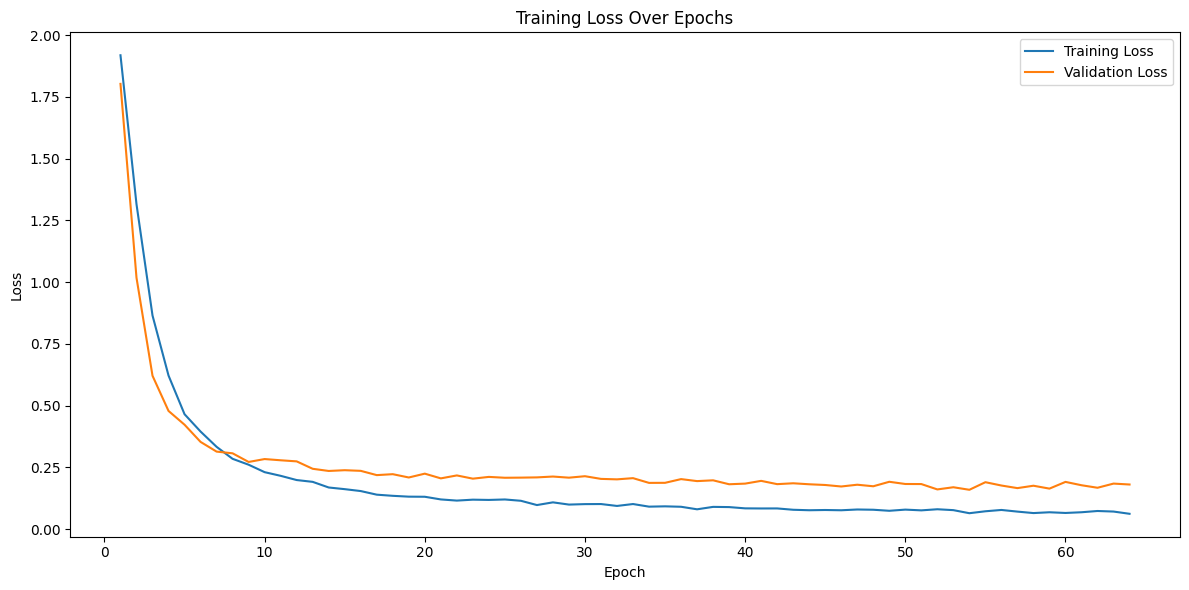

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 95.48333333333333%
Confusion Matrix:
[[575   1   9  13   2   0   0   0   0   0]
 [  0 583   2   1   1   0   0   0   0  13]
 [  6   0 558  20  12   0   1   0   3   0]
 [  1   0  15 560   0   0   4   1  19   0]
 [  0  21   1   0 571   5   0   1   0   1]
 [  0   4   0   0  16 573   1   0   0   6]
 [  0   0   0   2   0   0 579   0  19   0]
 [  0   0   0  10  10   4   1 567   6   2]
 [  0   0  17   0   0   0   2   0 581   0]
 [  0   8   0   9   0   1   0   0   0 582]]


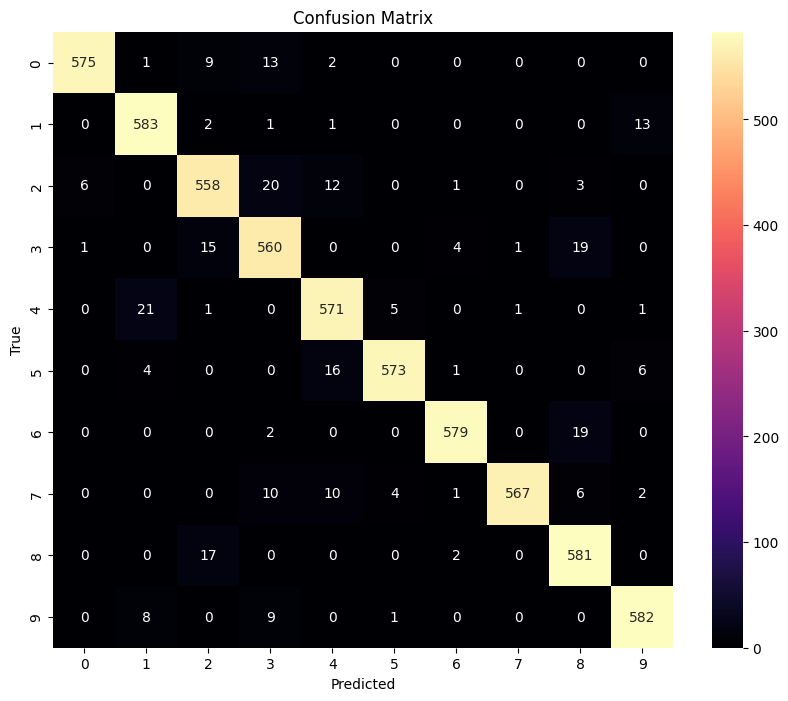

Classification Report:
              precision    recall  f1-score   support

           0    0.98797   0.95833   0.97293       600
           1    0.94489   0.97167   0.95809       600
           2    0.92691   0.93000   0.92845       600
           3    0.91057   0.93333   0.92181       600
           4    0.93301   0.95167   0.94224       600
           5    0.98285   0.95500   0.96872       600
           6    0.98469   0.96500   0.97475       600
           7    0.99649   0.94500   0.97006       600
           8    0.92516   0.96833   0.94625       600
           9    0.96358   0.97000   0.96678       600

    accuracy                        0.95483      6000
   macro avg    0.95561   0.95483   0.95501      6000
weighted avg    0.95561   0.95483   0.95501      6000



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_probabilities.extend(torch.exp(outputs.to('cpu')).tolist())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

confusion = confusion_matrix(all_labels, all_predicted)
print(f"Test Accuracy: {100 * correct / total}%")
print("Confusion Matrix:")
print(confusion)

fig = plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="magma", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(all_labels, all_predicted, digits=5)
print("Classification Report:")
print(report)

In [15]:
torch.save(model.state_dict(), "spectrogram_cnn.pth")